In [1]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
import numpy as np
from datetime import timedelta, datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data: what happened so far?

**Selection**: what are relevant characteristica?

**Cleaning**: 
- missing values in MODEL: 2
    - using the historical records of that VIN fill in the missing MODEL values
- engineer new feature: MAKE + MODEL + MODEL_YEAR
    - unique MAKE_MODEL_YEAR: 11684
    - total records: 187503
- drop: MODEL, MAKE, ZIP_CODE
- if a vehicle has multiple records from the same date, keep first record
    - records where vehicles got tested more than 1 time a day: 4046
    - after removing repeated tests from same day
        - total number of records: 187503 > 183457 
        - P: 173762 > 170120
        - F: 13741 > 13337
        - data range: 2013-01-01/2020-12-31 
- engineer feature: VEHICLE_AGE
- extract month, weekday, hour from TEST_SDATE: pause!!!
    - testing time ~ testing outcome??   
- drop TEST_SDATE
- map to numeric: TEST_TYPE:{'I':0, 'A':1}, TRANS_TYPE:{'A':0, 'M':1}
- drop VEHICLE_TYPE
    - near 1000 MAKE_MODEL_YEARs had more than 1 VEHICLE_TYPE 
    - it's not clear how vehicle types were defined
- dropped CYL
    - share of fail is higher when CYL is 9, 12 and R
    - but these are very few values
- drop FUEL_TYPE (FUEL_TYPE L only has 4 records and all are Pass)
    - more than 95% of the tests have FUEL_TYPE G
- 0 in GVWR: 11577 (P: 11090, F: 487)
    - set 0 to np.nan
    - fill in missing values using other records having the same VIN
        - left missing values: 7963 (P: 7564, F: 399)
- 0 in ODOMETER: 875 --- excluded!
    - P:    746
    - F:    129

In [2]:
# get original data
data_src = Path("data/sample201320.csv")
df_full = pd.read_csv(data_src, low_memory=False, sep=',')
df_full = df_full[(df_full.OVERALL_RESULT == "F") | (df_full.OVERALL_RESULT == "P")]
df_full['OVERALL_RESULT'].value_counts(normalize=True) * 100

P    92.671584
F     7.328416
Name: OVERALL_RESULT, dtype: float64

In [3]:
# get clean data
data_src = Path("data/clean_data_20210505.csv")
df = pd.read_csv(data_src, low_memory=False, sep=',')
df.shape
df['RESULT'].value_counts(normalize=True) * 100

1    92.655639
0     7.344361
Name: RESULT, dtype: float64

# What are the characteristica?

In [4]:
list(df.columns)

['RecordID',
 'RESULT',
 'TEST_TYPE',
 'ENGINE_SIZE',
 'TRANS_TYPE',
 'ODOMETER',
 'MAKE_MODEL_YEAR',
 'VEHICLE_AGE',
 'GVWR']

## TEST_TYPE
* Initial
* Retest

C:\Users\Oswin\anaconda3\lib\site-packages\seaborn\axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


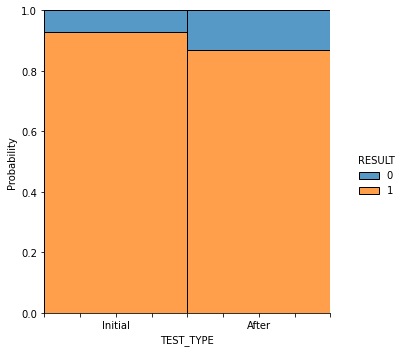

In [5]:
g_tt = sns.displot(data=df, x='TEST_TYPE', hue='RESULT', multiple='fill', discrete=True, stat='probability')
g_tt.set(xticklabels=["","","Initial","","","", "After","",""]) 

## GVWR

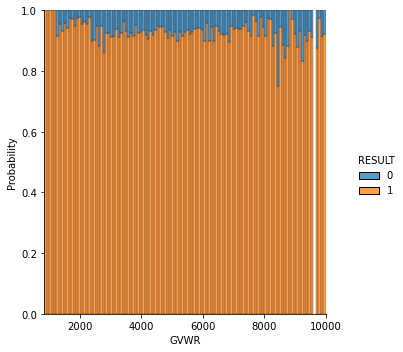

In [6]:
sns.displot(data=df, x='GVWR', hue='RESULT', multiple='fill', discrete=False, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

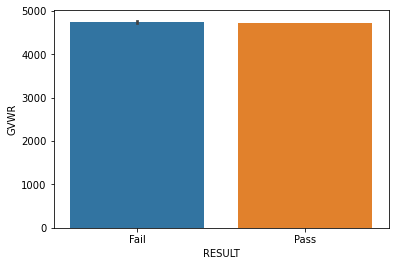

In [7]:
g_w = sns.barplot(x='RESULT', y='GVWR', data=df)
g_w.set(xticklabels=["Fail","Pass"]) 

## ENGINE_SIZE

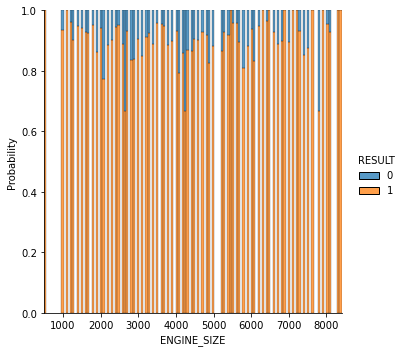

In [8]:
sns.displot(data=df, x='ENGINE_SIZE', hue='RESULT', multiple='fill', discrete=False, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

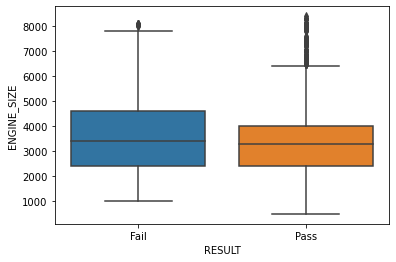

In [9]:
g_e = sns.boxplot(data=df, y='ENGINE_SIZE', x='RESULT')
g_e.set(xticklabels=["Fail","Pass"]) 

## TRANS_TYPE

C:\Users\Oswin\anaconda3\lib\site-packages\seaborn\axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


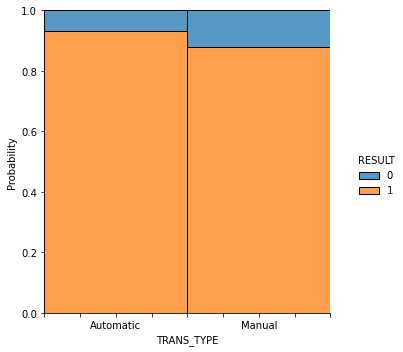

In [10]:
g_t = sns.displot(data=df, x='TRANS_TYPE', hue='RESULT', multiple='fill', discrete=True, stat='probability')
g_t.set(xticklabels=["","","Automatic","","","", "Manual","",""]) 

## ODOMETER

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

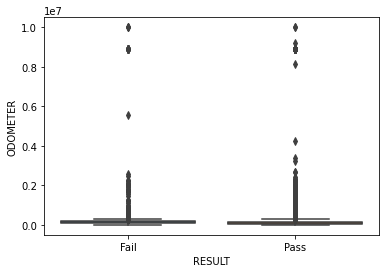

In [11]:
g_o = sns.boxplot(data=df, y='ODOMETER', x='RESULT')
g_o.set(xticklabels=["Fail","Pass"]) 

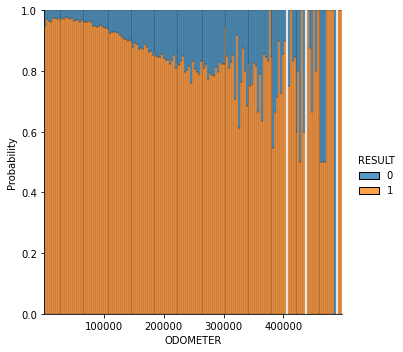

In [12]:
sns.displot(data=df[df['ODOMETER'] < 500000], x='ODOMETER', hue='RESULT', multiple='fill', discrete=False, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

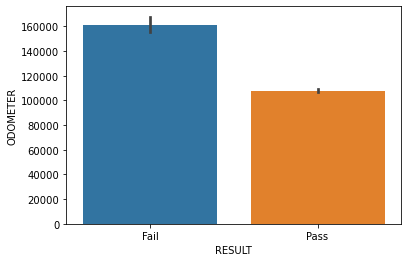

In [13]:
g_ob = sns.barplot(x='RESULT', y='ODOMETER', data=df)
g_ob.set(xticklabels=["Fail","Pass"]) 

## MAKE_MODEL_YEAR

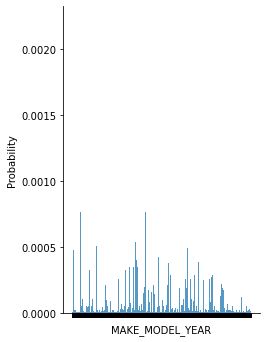

In [20]:
g1 = sns.displot(data=df[df.RESULT == 1], x='MAKE_MODEL_YEAR', discrete=True, stat='probability')
g1.set(xticklabels=[])

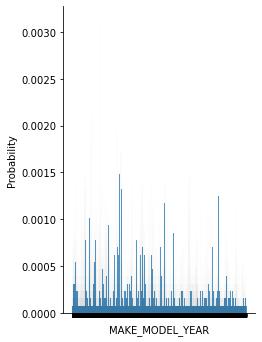

In [21]:
g2 = sns.displot(data=df[df.RESULT == 0], x='MAKE_MODEL_YEAR', discrete=True, stat='probability')
g2.set(xticklabels=[])

## VEHICLE_AGE

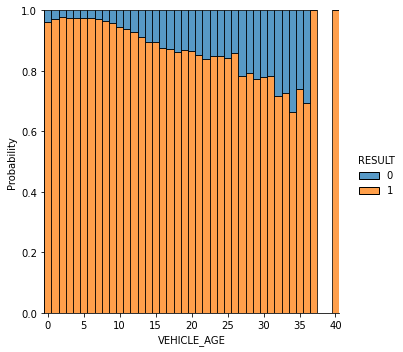

In [22]:
sns.displot(data=df, x='VEHICLE_AGE', hue='RESULT', multiple='fill', discrete=True, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

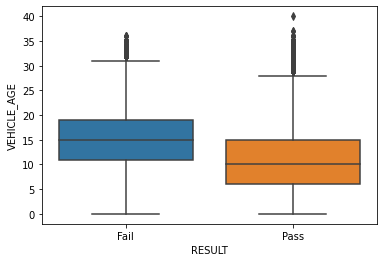

In [23]:
g_a = sns.boxplot(x='RESULT', y='VEHICLE_AGE', data=df)
g_a.set(xticklabels=["Fail","Pass"]) 

# Do any characteristics relate to one another?

## Correlation of our metric variables

<AxesSubplot:>

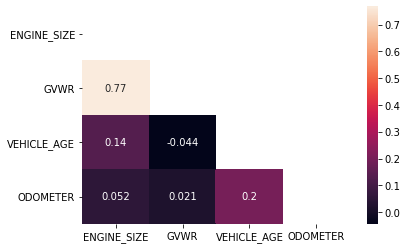

In [24]:
# correlation stuff
cols = ['ENGINE_SIZE', 'GVWR', 'VEHICLE_AGE', 'ODOMETER']
df_cor = df[cols].copy()
# show some correlations
matrix = np.triu(df_cor.corr())
sns.heatmap(df_cor.corr(), annot=True, mask=matrix)

## Variance Inflation Factor

In [25]:
# selecting columns
codes, uniques = pd.factorize(df['MAKE_MODEL_YEAR'])
cols = ['RESULT', 'TEST_TYPE', 'ENGINE_SIZE', 'TRANS_TYPE', 'ODOMETER', 'VEHICLE_AGE', 'GVWR']
df_vif = df[cols].copy()
df_vif['MAKE_MODEL_YEAR'] = codes

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i)
                          for i in range(len(df_vif.columns))]
  
print(vif_data)

           feature        VIF
0           RESULT   8.176861
1        TEST_TYPE   1.020905
2      ENGINE_SIZE  21.344069
3       TRANS_TYPE   1.209103
4         ODOMETER   1.315255
5      VEHICLE_AGE   4.347421
6             GVWR  23.724698
7  MAKE_MODEL_YEAR   3.239961
